<a href="https://colab.research.google.com/github/RajaBabu15/PINNs/blob/main/PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyDOE

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch import Tensor
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs  #Latin HyperCube Sampling
import scipy.io


torch.set_default_dtype(torch.float64)

torch.manual_seed(1234)
np.random.seed(1234)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    torch.cuda.manual_seed_all(1234)
    print(torch.cuda.get_device_name(0))
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True

cuda


In [ ]:
def plot3D(x, t, y):
  x_plot=x
  t_plot=t
  X,T=torch.meshgrid(x_plot,t_plot)
  F_xt=y
  fig,ax=plt.subplots(1,1)
  cp=ax.contourf(X,T,F_xt,20,cmap='rainbow')
  fig.colorbar(cp)
  ax.set_title('F(x,t)')
  ax.set_xlabel('x')
  ax.set_ylabel('t')
  plt.show()
  ax=plt.axes(projection='3d')
  ax.plot_surface(T.numpy(),X.numpy(),F_xt.numpy(),cmap='rainbow')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('F(x,t)')
  plt.show()


In [ ]:
def plot3D_Matrix(x,t,y):
  X,T=x,t
  F_xt=y
  fig,ax=plt.subplots(1,1)
  cp=ax.contourf(T,X,F_xt,20,cmap='rainbow')
  fig.colorbar(cp)
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax=plt.axes(projection='3d')
  ax.plot_surface(T.numpy(),X.numpy(),F_xt.numpy(),cmap='rainbow')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('F(x,t)')
  plt.show()


In [ ]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


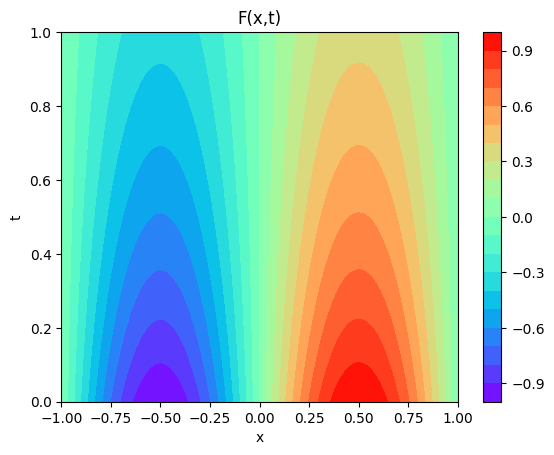

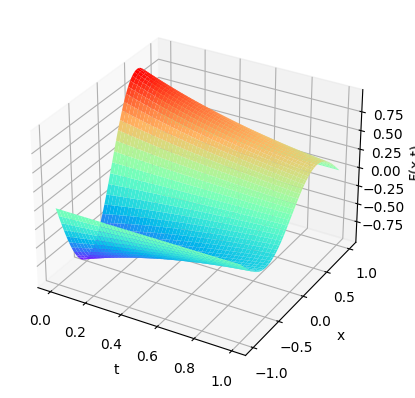

In [ ]:
x=torch.linspace(-1,1,200)
t=torch.linspace(0,1,100)
X,T=torch.meshgrid(x,t)
y_real=f_real(X,T)
plot3D(x,t,y_real)

In [ ]:
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None]
lb=x_test[0]
ub=x_test[-1]
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


In [ ]:
left_x=torch.hstack((X[:,0][:,None],T[:,0][:,None]))
left_y=torch.sin(np.pi*left_x[:,0]).unsqueeze(1)

bottom_x=torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))
bottom_y=torch.zeros(bottom_x.shape[0],1)

top_x=torch.hstack((X[0,:][:,None],T[0,:][:,None]))
top_y=torch.zeros(top_x.shape[0],1)

X_train=torch.vstack([left_x,bottom_x,top_x])
y_train=torch.vstack([left_y,bottom_y,top_y])

Nu=100
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=y_train[idx,:]

#Collocation Pts
Nf=10000
X_train_Nf=lb+(ub-lb)*lhs(2,Nf)
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu))



In [ ]:
X_train_Nu=X_train_Nu.float().to(device)
Y_train_Nu=Y_train_Nu.float().to(device)
X_train_Nf=X_train_Nf.float().to(device)
f_hat=torch.zeros(X_train_Nf.shape[0],1).to(device)

X_test=x_test.float().to(device)
Y_test=y_test.float().to(device)

In [ ]:


class FCN(nn.Module):
    def __init__(self, layers):
        super(FCN, self).__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        for i in range(len(self.linears)):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

        # Convert all parameters to float32
        self.float()

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = x.float()  # Convert input to float32
        for i in range(len(self.linears)-1):
            a = self.activation(self.linears[i](a))
        a = self.linears[-1](a)  # Last layer without activation
        return a

    def lossBC(self, x_BC, y_BC):
        loss_BC = self.loss_function(self.forward(x_BC.float()), y_BC.float())
        return loss_BC

    def lossPDE(self, x_PDE):
        g = x_PDE.clone().float()
        g.requires_grad = True
        f = self.forward(g)
        f_x_t = autograd.grad(f, g, torch.ones([g.shape[0], 1]).to(g.device), retain_graph=True, create_graph=True)[0]
        f_xx_tt = autograd.grad(f_x_t, g, torch.ones(g.shape).to(g.device), create_graph=True)[0]
        f_t = f_x_t[:, [1]]
        f_xx = f_xx_tt[:, [0]]

        # Define f_hat as a float32 tensor, if not already defined
        f_hat = torch.zeros_like(f_t)  # Example: replace with actual f_hat definition

        f = f_t - f_xx + torch.exp(-g[:, 1:]).float() * torch.sin(np.pi * g[:, 0:1].float()) - np.pi**2 * torch.sin(np.pi * g[:, 0:1].float())
        return self.loss_function(f, f_hat.float())

    def loss(self, x_BC, y_BC, x_PDE):
        return self.lossBC(x_BC, y_BC) + self.lossPDE(x_PDE)


In [ ]:
layers=np.array([2,32,64,1])
PINN=FCN(layers)
PINN.to(device)
print(PINN)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
optimizer=torch.optim.Adam(PINN.parameters(),lr=0.001,amsgrad=False)

In [ ]:
for i in range(20_000):
  loss=PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i%(20_000/10)==0:
    with torch.no_grad():
      test_loss=PINN.lossBC(X_test,Y_test)
    print("training:",loss,"/Testing",test_loss)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


training: tensor(41.6375, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.1165, device='cuda:0', dtype=torch.float32)
training: tensor(0.0033, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.0670, device='cuda:0', dtype=torch.float32)
training: tensor(0.0011, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.0628, device='cuda:0', dtype=torch.float32)
training: tensor(0.0003, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.0612, device='cuda:0', dtype=torch.float32)
training: tensor(0.0002, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.0612, device='cuda:0', dtype=torch.float32)
training: tensor(0.0001, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.0610, device='cuda:0', dtype=torch.float32)
training: tensor(0.0002, device='cuda:0', dtype=torch.float32, grad_fn=<AddBackward0>) /Testing tensor(0.

In [ ]:
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

In [ ]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_t1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

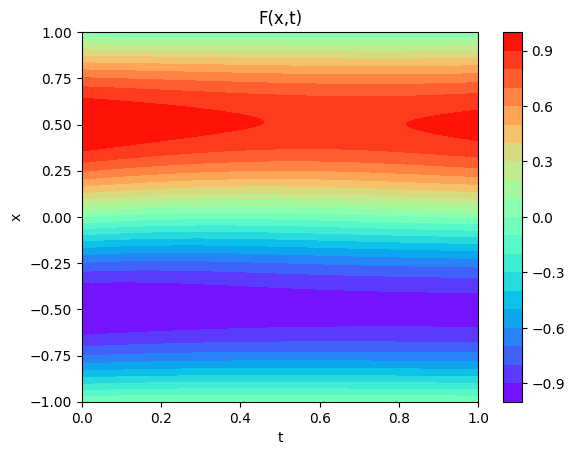

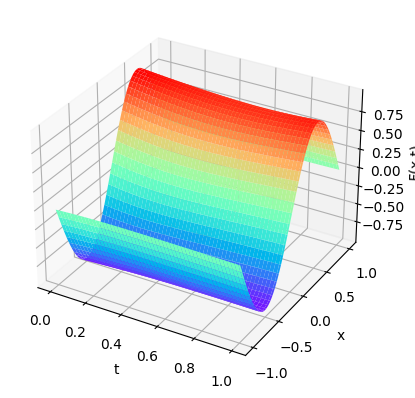

In [ ]:
plot3D_Matrix(arr_x1,arr_t1,arr_y1)

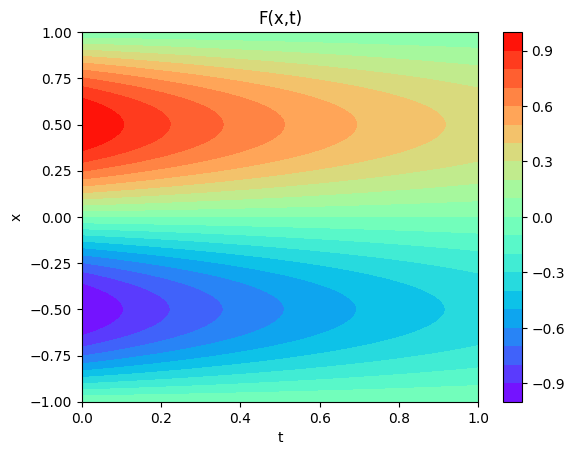

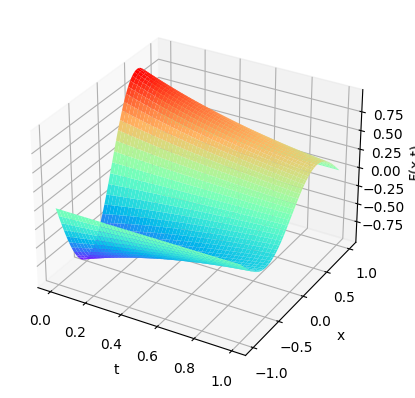

In [ ]:
plot3D_Matrix(X,T,y_real)